# Stochastic simulation algorithm
<hr>

## Summary
The _stochastic simulation algorithm_ (SSA) was developed over the twentieth century, like most other MC methods. A sizeable fraction of the literature is dedicated to either improving it's complexity, or implementing it to investigate the properties of reactive chemical mixtures. Here, the SSA is formulated in the introduction, two versions are written wih Python 3 in the implementation section, and these are used in the applications section to perform simulations of a simple epidemic.

## Introduction

It is likely that the SSA has been well-formulated in probability theory for a good deal of time, but in the context of this discussion, it was first described in 1976 by Daniel T. Gillespie as _a systematic, computer-oriented procedure in which rigorously derived Monte Carlo techniques are employed to numerically simulate the very Markov process that the master equation describes analytically._ In Gillespie's works, the SSA was implemented to simulate processes known as reactive chemical mixtures. In such processes, a set of chemical species spontaneously form and break bonds with each other following a so-called stoichiometry, which can be quite simple (i.e. the reaction has a single elementary reaction or event), or be inoordinately complex (the reaction has many thousands of elementary reactions or events). For example, the reaction $2H_{2} + O_{2} \rightarrow 2H_{2}O$ is known to involve about eight unique species and about twenty elementary events, depending on the conditions. In this way, the reaction might start off with a lot of $H_{2}$ and $O_{2}$ molecules, but as time goes by their populations shrink as others grow, and then those others shrink as $H_{2}O$ grows, and so forth (vauguely speaking). Also, humans are reactive chemical mixtures.

In any reactive chemical mixture, each elementary event has a so-called propensity, and this propensity depends on the composition (i.e. the set of chemical species). The ontology is simple- elementary events with greater-magnitude propensity are either more likely to occur and/or likely to occur more frequently than elementary events with smaller-magnitude propensity. In their works on SSA, Gillespie derives propensity expressions from first principals for certain kinds of elementary events, which can then be used to simulate certain reactive chemical mixtures. The extension of propensities to elementary events of any Markov process is generally always possivle, but their derivation must be handled with care to produce accurate simulation results.

For reactive chemical mixtures, propensities almost always depend on the composition at the current time, which is denoted by $x_{t}$. Thus, for an elementary event, it's propensity is denoted $c_{j}(x_{t})$. Now, the so-called _fundamental hypothesis of the stochastic formulation of chemical kinetics_ endows propensities with the following property

$$c_{j}(x_{t}) \delta t + o(\delta t):= \text{average probability, to first order in }\delta t \text{, that elementary reaction }j\text{ will occur in the next time interval }\delta t,$$

where $j$ refers to the index of the elementary event (exercise: give the dimension of $c_{j}(x_{t})$). Note that there is no special way to sort the $j$ elementary events at implementation time, but for the SSA to work, they should remain sorted as they were in the first iteration. The probabilistic interpretation of each $c_{j}(x_{t})$ means that $j$ is a random variable, such that

$$p(j) = \frac{c_{j}(x_{t})}{\sum_{j}c_{j}(x_{t})},$$

which can be exploited in a MC step.

The next consideration in formulating the SSA is to find a probabilistic expression for the _time to the next elementary event, $\tau$. In queuing theory $\tau$ is called the _sojourn time_. In basically _every single_ Markov process, the sojourn time, is exponentially distributed. So then

$$p(\tau) = exp(-\sum_{j}c_{j}(x_{t})\tau),$$

which can also be exploited in a MC step.

As can be seen, the SSA simulates a Markov process by considering two (really interesting, deeply philosophical) procedural facets: how the system updates it's populations (i.e. $p(j)$), and how long the system waits until it performs another update of it's populations (i.e. $p(\tau)$). Thus each iteration within a single simulation requires at least two MC steps.

To update populations the following is evaluated with a pseudorandom float, $r$, on $[0,1]$ (exercise: explain what is going on in this MC step in the context of a reactive chemical mixture):

$$j = \text{the smallest integer satisfying} \sum_{\hat{j}}^{j} c_{\hat{j}}(x_{t}) > r\sum_{j}c_{j}(x_{t})$$

To find the sojourn time, the familiar exponential distribution inversion is invoked with another pseudorandom float on $[0,1]$:

$$\tau = \frac{1}{\sum_{j}c_{j}(x_{t})}log_{e}(\frac{1}{r})$$

So, the "direct-method" of the SSA is as follows:

1. Initialize the time $t = t_{0}$ and systems state to $x=x_{0}$
2. Evaluate each $c_{j}$ if it depends on $x$ or $t$, and compute $\sum_{j}c_{j}(x_{t})$
3. Evaluate the Monte Carlo steps to update $t$ and $x$
4. Update $t$ and $x$ as desired
5. Return to step 2 or else exit the simulation

The "first-reaction" method of the SSA, which in a way discounts all the theory behind the direct method, is as follows (exercise: explain why this version works):

1. Initialize the time $t = t_{0}$ and systems state to $x=x_{0}$
2. Draw $j$ pseudorandom numbers and compute a $\hat{\tau}$ with each one
3. Set $\tau$ as the smallest $\hat{\tau}$, and $j$ as the index of the chosen $\hat{\tau}$
4. Update $t$ and $x$ as desired
5. Return to step 2 or else exit the simulation

## Implementation
The SSAs as presented above follow the literautre published by Gillespie, but are naive in at least one respect: they don't specify how to avoid updating the system's categorical populations in nonsensical ways. For example, without certain precautions, it could be possible for a given species' population to dip below zero, which is nonsense. This can be resolved by implementing additional logic that regulates it's populations, the possible/impossible elementary events, and determines when a simulation should be complete.

### A container for all the "unimportant" logic, `SSAModel`
As a pretty general approach to such logic, consider the following "model" class, inhereting from a built-in dictionary, which was designed to offload the control-flow issues described in the above paragraph from the SSAs to itself, thus reducing those tasks to single calls to it's public members. Detailed functionality is given by a full breakdown of each member after the source code.

In [1]:
class SSAModel(dict):
    """Container for SSA model"""

    def __init__(
        self,
        initial_conditions,
        propensities,
        stoichiometry,
        max_duration=None
    ):
        """Initialize model"""

        # populate the model
        super().__init__(**initial_conditions)

        # set maximum simulation time for any trajectory
        self.max_duration = max_duration

        # cat then sort propens and stoichs in event lists
        self.events = list()
        self.excluded_events = list()
        for event, propensity in propensities.items():
            if propensity(self) == 0.0:
                self.excluded_events.append(
                    (
                        event,
                        stoichiometry[event],
                        propensity
                    )
                )
            else:
                self.events.append(
                    (
                        event,
                        stoichiometry[event],
                        propensity
                    )
                )

    def exit(self):
        """Return True to break out of trajectory"""

        # return True if no more reactions
        if len(self.events) == 0:
            return True
        else:
            return False

        # return True if there is no time left
        if self.max_duration is not None:
            if self["time"][-1] >= self.max_duration:
                return True

    def curate(self):
        """Validate and invalidate elementary events"""
        
        # evaulate possible reactions
        events = []
        while len(self.events) > 0:
            event = self.events.pop()
            if event[2](self) == 0:
                self.excluded_events.append(event)
            else:
                events.append(event)
        events.sort()
        self.events = events

        # evaluate impossible reactions
        excluded_events = []
        while len(self.excluded_events) > 0:
            event = self.excluded_events.pop()
            if event[2](self) > 0:
                self.events.append(event)
            else:
                excluded_events.append(event)
        excluded_events.sort()
        self.excluded_events = excluded_events

    def reset(self):
        """Clear the trajectory"""

        # reset species to initial conditions
        for key in self:
            del self[key][1:]

        # reset reactions per initial conditions
        self.curate()

#### Member `SSAModel.__init__`
The initializer accepts four parameters: `initial_conditions: dict`, `propensities: dict`, `stoichiometry: dict`,`max_duration: float or NoneType`.

 - The `initial_conditions` parameter is a dictionary having key-value pairs typed in general like `string:numeric[]`. An example would be `{"species_a": [100], "species_b": [0], "time": [0.0]}`. Note that the key `"time"` must always be included with it's iterable containing an initial time. Any initial condition (for time or otherwise) with more than one specified in it's iterable will have those additional conditions truncated, leading to possibly erroneous results.
 - The `propensities` dictionary contains $j$ key-value pairs, whereby each key is an integer $\geq 1$ and $\leq j$, and each value is a function that instances of `SSAModel` can pass themselves to, thus evaluating that elementary event's propensity.
 - The `stoichiometry` paramater is a dictionary that contains $j$ key-value pairs, in correspondance with the `propensities` parameter, whereby each value is a dictionary that specifies how to update the model's species.
 - The `max_duration` parameter defaults to `None`, but can be a floating point number that specifies when the simulation should end.

After passing in these parameters, `SSAModel.__init__` will set the instance's key-value pairs to those specified by the `initial_conditions` parameter; then it sets the instance's `max_duration` parameter to the one passed in; then it will initialize the instance's `events` and `excluded_events` attributes with corresponding `(j, stoichiometry_j, propensity_j)` elementary event tuples.

#### Member `SSAModel.exit`
This method is called by the SSA with no parameters at the start of each iteration within one simulation (note another word for "one simulation" is "trajectory") to see if the trajectory is complete. Specifically, this method asks it's instance if there are no more possible elementary events or if the trajectory has reached `SSAModel.max_duration`, and will return `True` if so. Thus, the iterating loop for a trajectory for the proceding SSA implementation will be of the form `while not SSAModel.exit(): ...`.

#### Member `SSAModel.curate`
This method is called by the SSA with no parameters at the end of each iteration within one trajectory to comb out impossible elementary events (setting them in `SSAModel.excluded_events`), and to reset events back into `SSAModel.events` those that have become possible again.

#### Member `SSAModel.reset`
This method is called by the SSA with no parameters at the end of each trajectory to truncate all of `SSAModel`'s values (which again are iterables) to their first, or "inital" value. Exersice: extend `SSAModel` so that this member accepts a single parameter, `n`, such that the first $n$ entries of each iterable are not truncated.

### Container for the algorithm, `SSA`
There are many interesting ways to implement the SSA, and there are many interesting implementations that currently exist. The approach herein is to use a class called `SSA`, that is initialized by passing in a `SSAModel` instance and a pseudorandom number generator (which we use our dear friend Mersenne), whereby it's members are _indefinite generators_ of SSA trajectories. Here is the implementation (which has generators for the direct-method and first-reaction method), followed by some exercises:

In [2]:
from math import log

from montecarlo import Mersenne


class SSA:
    """Container for SSAs"""

    def __init__(self, model, seed=1234):
        """Initialize container with model"""
        self.model = model
        self.random = Mersenne(seed=seed)

    def direct(self):
        """Indefinite generator of direct-method trajectories"""
        while True:
            while not self.model.exit():
                
                # evaluate weights and partition
                weights = [
                    (rxn, sto, pro(self.model))
                    for (rxn, sto, pro)
                    in self.model.events
                ]
                partition = sum(w[-1] for w in weights)

                # evaluate sojourn time
                sojourn = log(
                    1.0 / self.random.floating()
                ) / partition
                self.model["time"].append(
                    self.model["time"][-1] + sojourn
                )

                # evaluate the reaction
                partition = partition * self.random.floating()
                while partition >= 0.0:
                    rxn, sto, pro = weights.pop(0)
                    partition -= pro
                for species, delta in sto.items():
                    self.model[species].append(
                        self.model[species][-1] + delta
                    )

                self.model.curate()
            yield self.model
            self.model.reset()
            
    def first_reaction(self):
        """Indefinite generator of 1st-reaction trajectories"""
        while True:
            while not self.model.exit():

                # evaluate next reaction times
                times = [
                    (
                        log(
                            1.0 / self.random.floating()
                        ) / pro(self.model),
                        sto
                    )
                    for (rxn, sto, pro) in self.model.events
                ]
                times.sort()

                # evaluate reaction time
                self.model["time"].append(
                    self.model["time"][-1] + times[0][0]
                )

                # evaluate reaction
                for species, delta in times[0][1].items():
                    self.model[species].append(
                        self.model[species][-1] + delta
                    )

                self.model.curate()
            yield self.model
            self.model.reset()

Exercise: to each line (except whitespace) in `SSA`'s members, assign the corresponding step number from the direct-method algorithm.

Exercise: to each line ..., assign corresponding step number from the first-reaction-method algorithm.

Exercise: Show how each iterable (except the `"time"` iterable) of an `SSAModel` instance is a Markov chain after exiting the inner while loop of either method.

Exercise: Show how the `"time"` iterable of an `SSAModel` instance can be transformed into a Markov chain with a list comprehension. Explain why it is not such a chain as produced.

## Applications

### Studying epidemics like COVID-19
Regardless of the ontological aspects involved in Gillespie's work deriving the SSA, it is broadly applicable to many observable processes. Consider as an example the COVID-19 pandemic, in which a population of individuals are all initially in a susceptible state ($S$), and can transition to the infected ($I$) state by acquiring the virus. In the infected state, an individual can then either recover (state $R$) or die (state $D$). Supposing that the timescale of this pandemic is significantly shorter than the average lifespan of any individual, it can be assumed that transitions from the recovered state are not possible. Schematically, here are the possibilities--

$$S \rightarrow I$$

$$I \rightarrow D$$

$$I \rightarrow R$$

These graphs are represented in epidemiology as a system of ODEs, from which propensities can be extracted:

$$\frac{dS}{dt} = -\alpha S I$$

$$\frac{dI}{dt} = \alpha S I - \beta I - \gamma I$$

$$ \frac{dR}{dt} = \gamma I$$

The SSA can be used to approximate infection dynamics if $\alpha$, $\beta$, and $\gamma$ are known (exerice: what are they? State their dimensions). The following simulation is initialized with $500$ individuals, some of which are already infected so as to seed the process (Exercise: if no individual is infected, explain why the simulation will not occur). Follow the comments carefully.

In [3]:
# initial species counts and measurement time
initital_conditions = {
    "s": [480], # susceptible folks
    "i": [20], # infected folks
    "r": [0], # ... etc.
    "d": [0],
    "time": [0.0],
}


# propensity functions, note
# alpha = 0.01
# beta = 0.1
# gamma = 0.5
propensities = {
    0: lambda d: 0.01 * d["s"][-1] * d["i"][-1],
    1: lambda d: 0.1 * d["i"][-1],
    2: lambda d: 0.5 * d["i"][-1],
}


# change in species for each propensity
stoichiometry = {
    0: {"s": -1, "i": 1, "r": 0, "d": 0},
    1: {"s": 0, "i": -1, "r": 0, "d": 1},
    2: {"s": 0, "i": -1, "r": 1, "d": 0}
}

# NOTE:
# in event 0, one susceptible individual becomes infected
# in event 1: one infected individual becomes dead
# in event 2: one infected individual becomes recovered


# instantiate the epidemic SSA model
epidemic = SSAModel(
    initital_conditions,
    propensities,
    stoichiometry
)


# instantiate the SSA container with model,
# letting the PRNG default to Mersenne
epidemic_generator = SSA(epidemic)

All the basic ingredients necessary to simulate the epidemic are now in place. However, to visualize the results of the simulation, a column of plots is produced with each trajectory, as per below--

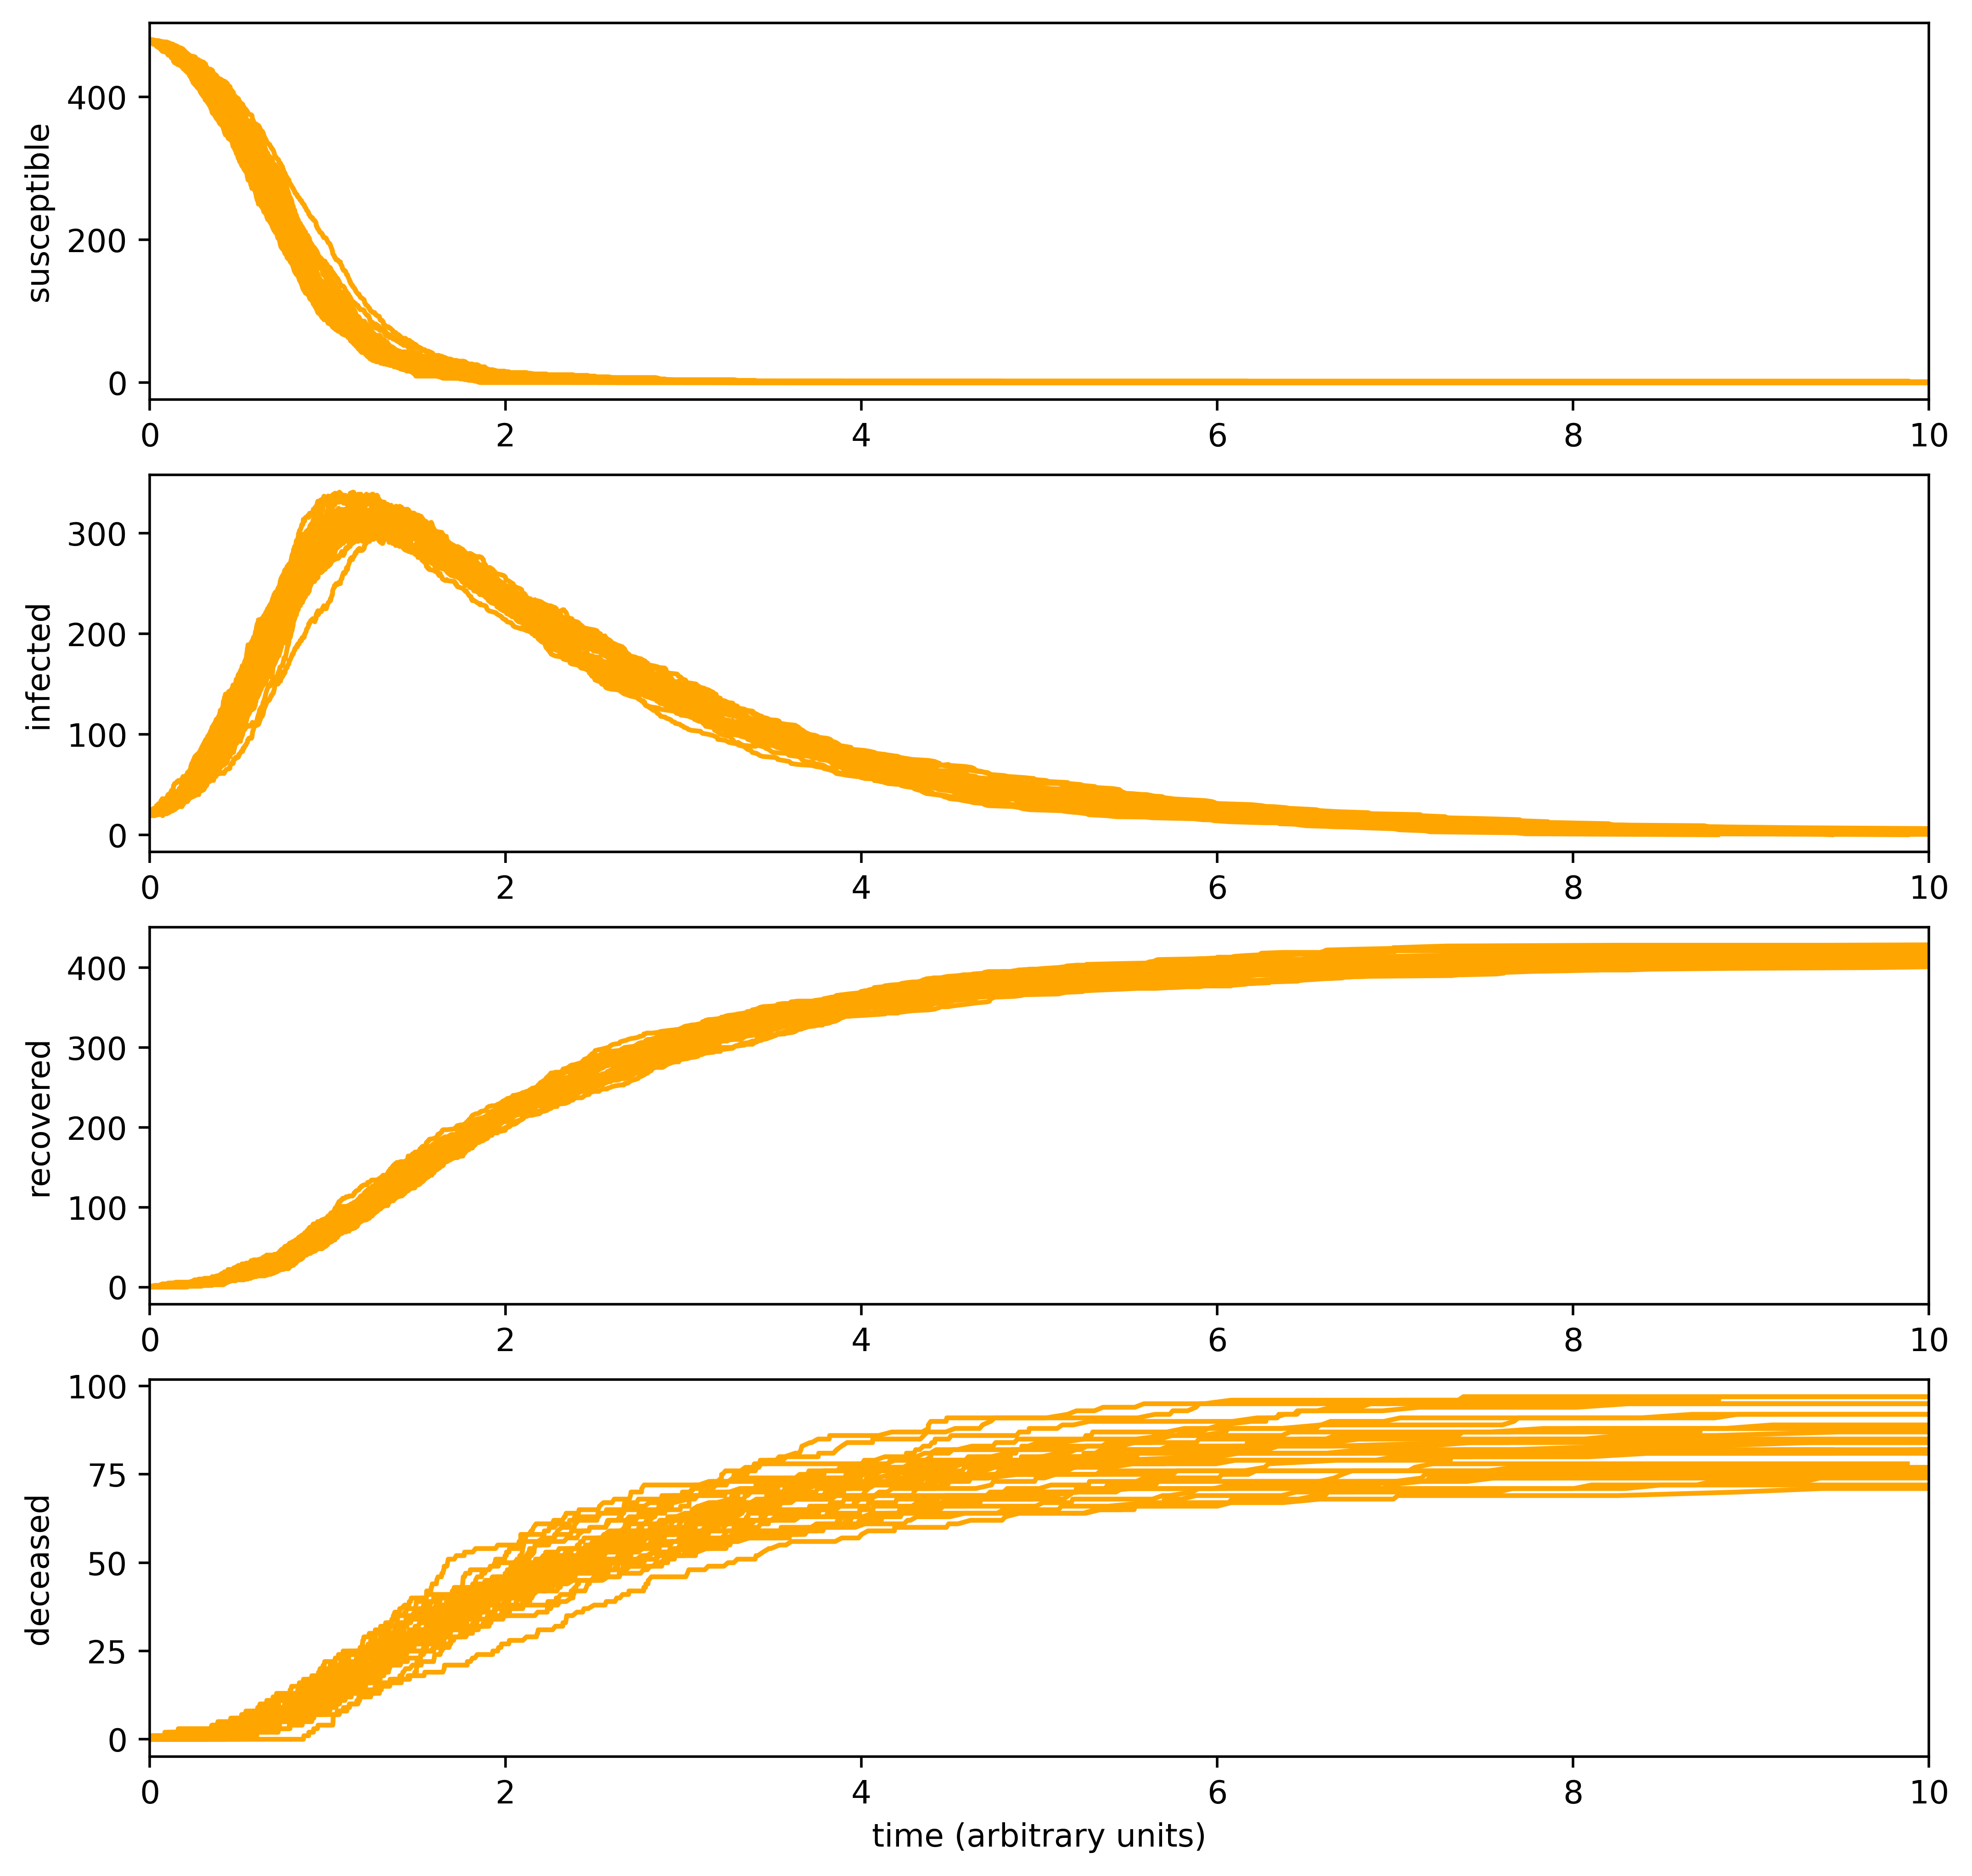

In [4]:
from matplotlib import pyplot


# make a nice, big figure
pyplot.figure(figsize=(10,10), dpi=500)


# make a subplot for susceptible individuals
axes_s = pyplot.subplot(411)
axes_s.set_xlim(0,10)
axes_s.set_ylabel("susceptible")

# make a subplot for infected individuals
axes_i = pyplot.subplot(412)
axes_i.set_xlim(0,10)
axes_i.set_ylabel("infected")

# make a subplot for recovered individuals
axes_r = pyplot.subplot(413)
axes_r.set_xlim(0,10)
axes_r.set_ylabel("recovered")

# make a subplot for deceased individuals
axes_d = pyplot.subplot(414)
axes_d.set_xlim(0,10)
axes_d.set_ylabel("deceased")
axes_d.set_xlabel("time (arbitrary units)")


# simulate and plot acceptable trajectories
trajectories = 0
for trajectory in epidemic_generator.direct():
    axes_s.plot(trajectory["time"], trajectory["s"], color="orange")
    axes_i.plot(trajectory["time"], trajectory["i"], color="orange")
    axes_r.plot(trajectory["time"], trajectory["r"], color="orange")
    axes_d.plot(trajectory["time"], trajectory["d"], color="orange")
    trajectories += 1
    if trajectories == 30:
        break

pyplot.show()

As seen in the plot, the significance of $\alpha$, $\beta$, and $\gamma$ is that about twenty percent of the population will die when they become infected. Now, consider the first-reaction method:

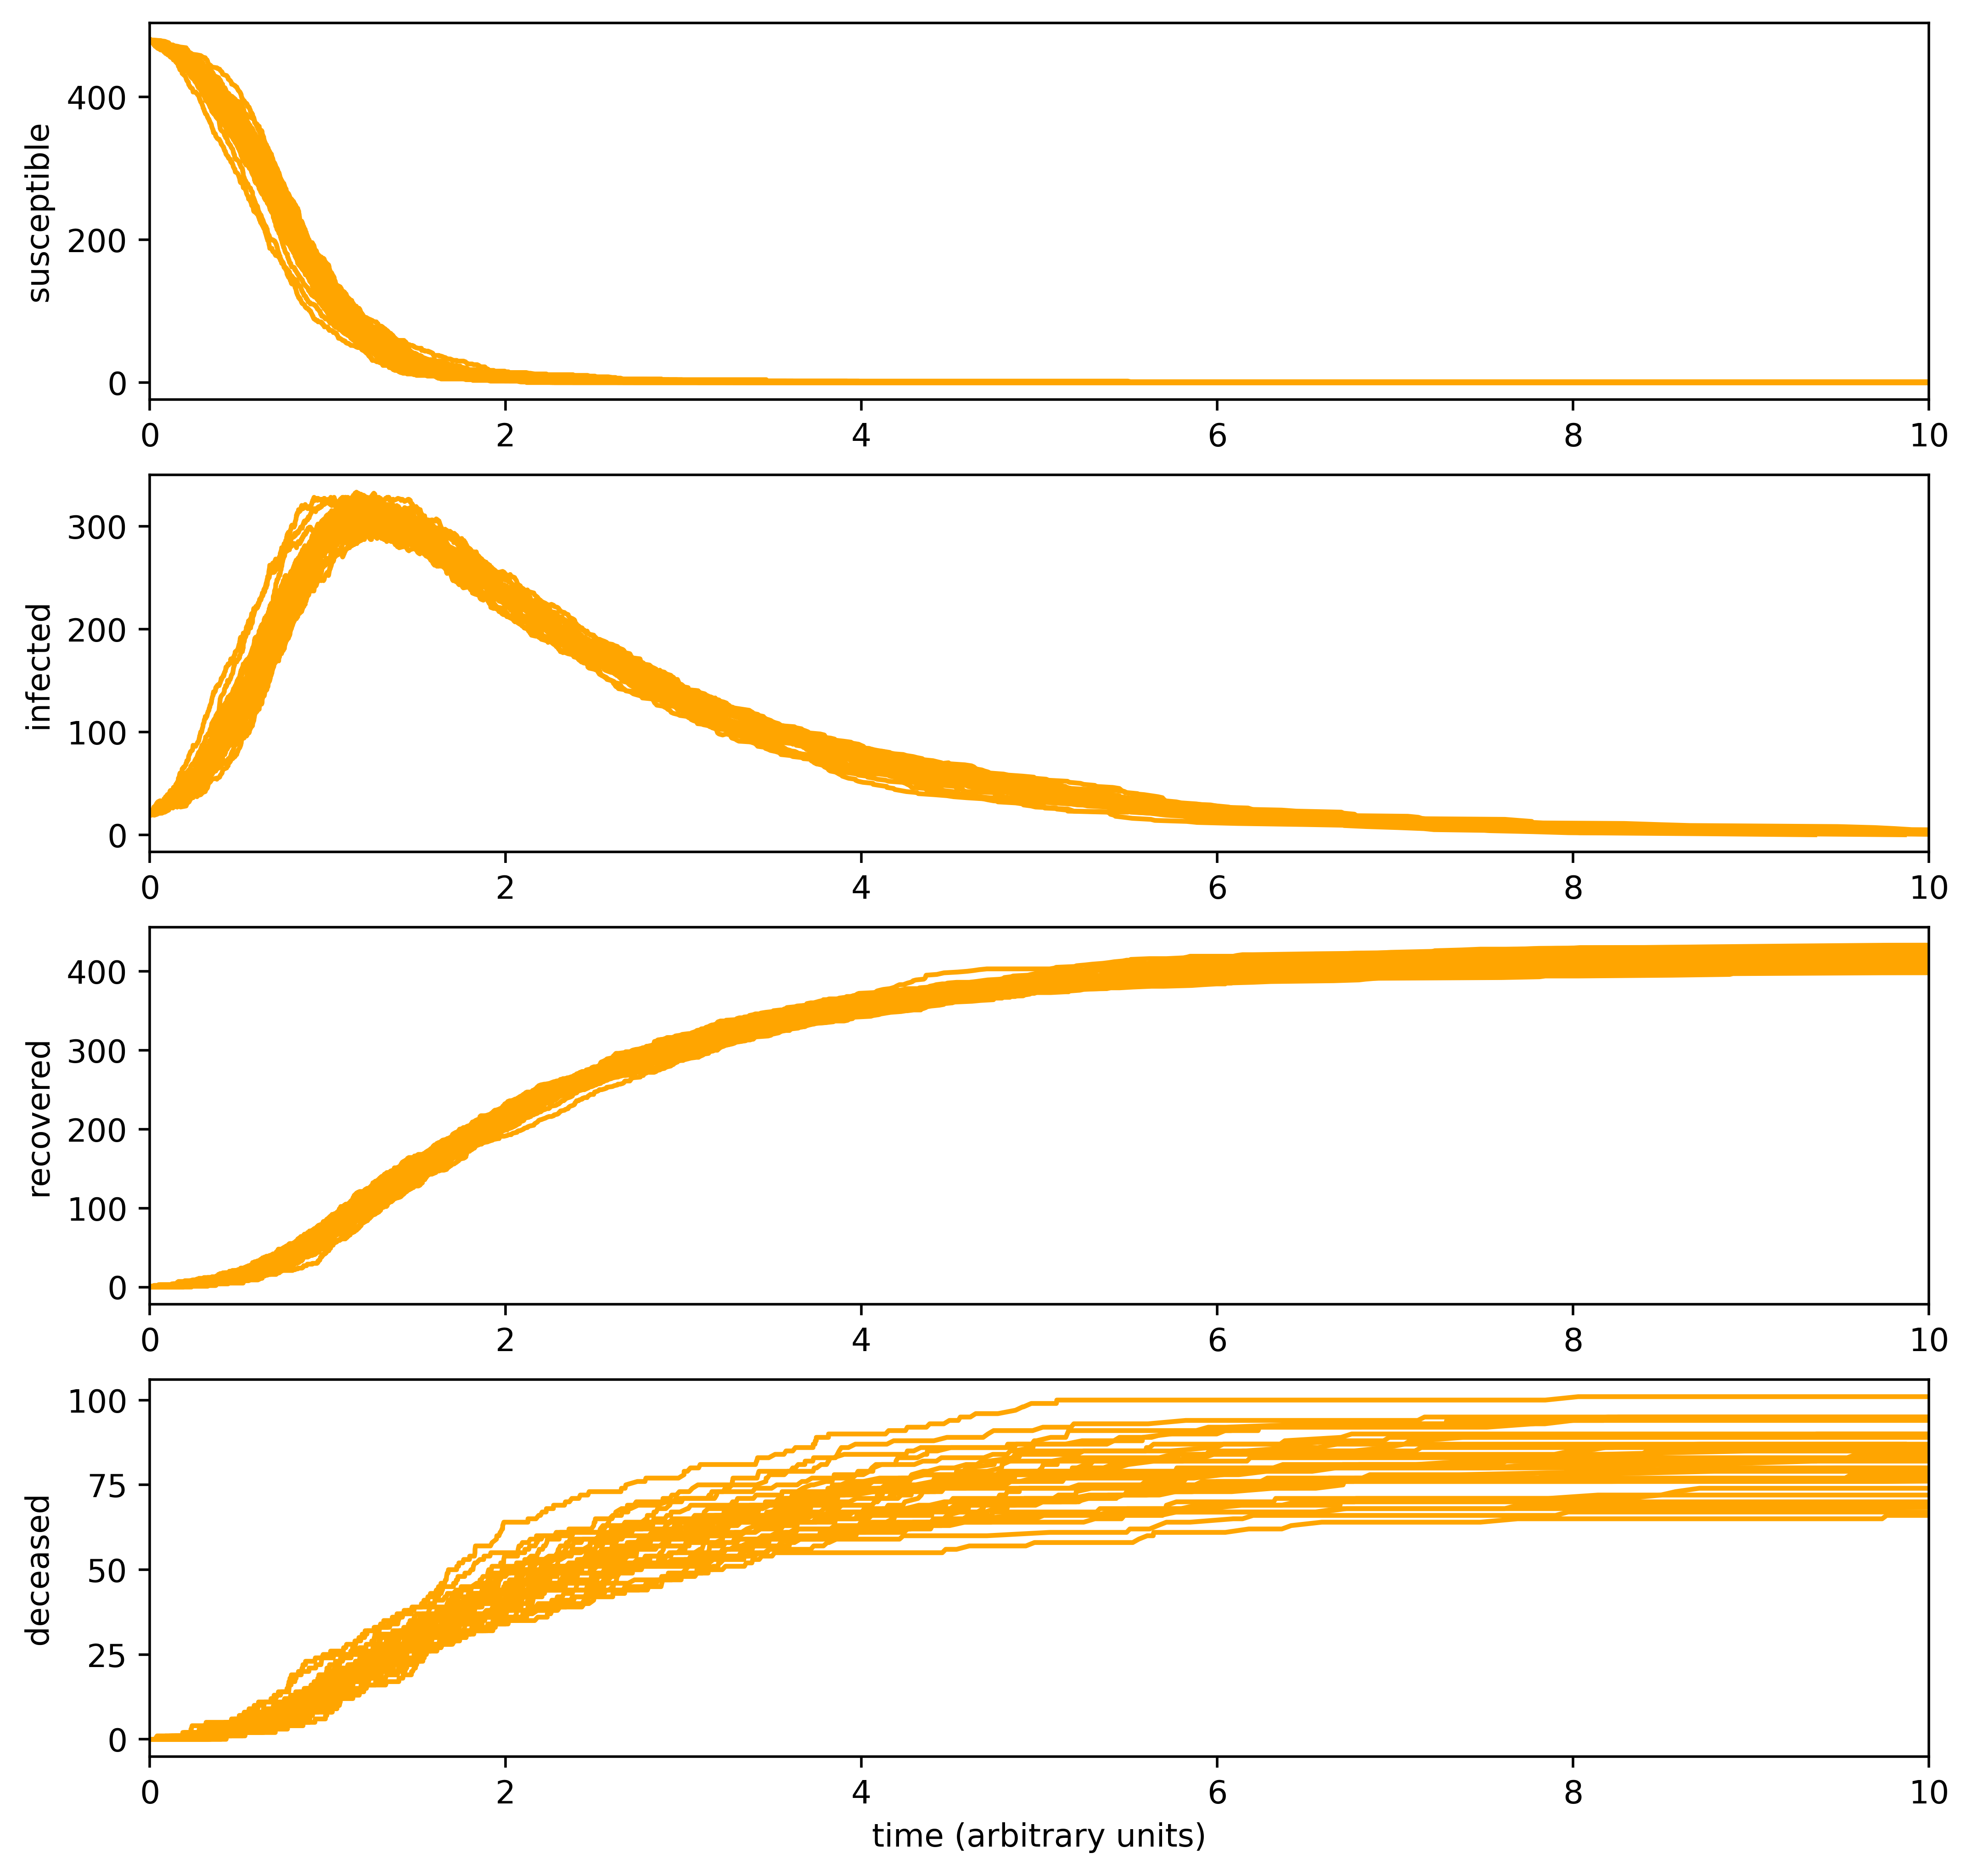

In [5]:
# reset pyplot's default figure
pyplot.figure(figsize=(10,10), dpi=500)


# make a subplot for susceptible individuals
axes_s = pyplot.subplot(411)
axes_s.set_xlim(0,10)
axes_s.set_ylabel("susceptible")

# make a subplot for infected individuals
axes_i = pyplot.subplot(412)
axes_i.set_xlim(0,10)
axes_i.set_ylabel("infected")

# make a subplot for recovered individuals
axes_r = pyplot.subplot(413)
axes_r.set_xlim(0,10)
axes_r.set_ylabel("recovered")

# make a subplot for deceased individuals
axes_d = pyplot.subplot(414)
axes_d.set_xlim(0,10)
axes_d.set_ylabel("deceased")
axes_d.set_xlabel("time (arbitrary units)")


# simulate and plot acceptable trajectories
trajectories = 0
for trajectory in epidemic_generator.first_reaction():
    axes_s.plot(trajectory["time"], trajectory["s"], color="orange")
    axes_i.plot(trajectory["time"], trajectory["i"], color="orange")
    axes_r.plot(trajectory["time"], trajectory["r"], color="orange")
    axes_d.plot(trajectory["time"], trajectory["d"], color="orange")
    trajectories += 1
    if trajectories == 30:
        break

pyplot.show()

## References and further reading

Gillespie, Daniel T. (2007). "Stochastic Simulation of Chemical Kinetics". The Journal of Physical Chemistry. 58: 35–55.

Gillespie, Daniel T. (1976). "A General Method for Numerically Simulating the Stochastic Time Evolution of Coupled Chemical Reactions". Journal of Computational Physics. 22 (4): 403–434.